In [1]:
import re
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['HF_DATASETS_OFFLINE'] = '1'

import torch
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.utils.data import DataLoader
from transformers import BertTokenizer

from semcom_model import MoE_SemCom, Transformer_SemCom, HetereoMoE_SemCom
from utils import collate_fn, SST2Dataset, fix_seed
from collections import defaultdict


# Setup
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
fix_seed(2026)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

# Load models
model_moe = MoE_SemCom(num_tasks=2, embed_dim=256, task_dim=8, num_experts=8, num_encd_layer=4, transmit_dim=128).to(device)
model_dense = Transformer_SemCom(num_tasks=2, embed_dim=256, task_dim=8, num_encd_layer=4, transmit_dim=128).to(device)
model_hetereo = HetereoMoE_SemCom(num_tasks=2, embed_dim=256, task_dim=8, num_experts=8, size_distribution='arithmetic', transmit_dim=128, num_encd_layer=4).to(device)  # NEW


model_moe.load_state_dict(torch.load("checkpoints/MoE_encdlayer_20250524_044548.pt", map_location=torch.device("cpu")))
model_dense.load_state_dict(torch.load("checkpoints/Dense_encdlayer_20250523_154825.pt", map_location=torch.device("cpu")))
model_hetereo.load_state_dict(torch.load("checkpoints/HetereoMoE_encdlayer_20250524_110806.pt", map_location=torch.device("cpu")))


model_moe.eval()
model_dense.eval()
model_hetereo.eval()


/home/necphy/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_3233681/3720992373.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weig

HetereoMoE_SemCom(
  (text_encoder): BERTTextEncoder(
    (bert_model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_feature

In [6]:
for name, param in model_dense.named_parameters():
    print(name, param.shape)

text_encoder.bert_model.embeddings.word_embeddings.weight torch.Size([30522, 768])
text_encoder.bert_model.embeddings.position_embeddings.weight torch.Size([512, 768])
text_encoder.bert_model.embeddings.token_type_embeddings.weight torch.Size([2, 768])
text_encoder.bert_model.embeddings.LayerNorm.weight torch.Size([768])
text_encoder.bert_model.embeddings.LayerNorm.bias torch.Size([768])
text_encoder.bert_model.encoder.layer.0.attention.self.query.weight torch.Size([768, 768])
text_encoder.bert_model.encoder.layer.0.attention.self.query.bias torch.Size([768])
text_encoder.bert_model.encoder.layer.0.attention.self.key.weight torch.Size([768, 768])
text_encoder.bert_model.encoder.layer.0.attention.self.key.bias torch.Size([768])
text_encoder.bert_model.encoder.layer.0.attention.self.value.weight torch.Size([768, 768])
text_encoder.bert_model.encoder.layer.0.attention.self.value.bias torch.Size([768])
text_encoder.bert_model.encoder.layer.0.attention.output.dense.weight torch.Size([768, 7

In [4]:
def count_params_exclude(model, exclude_prefixes=['text_encoder', 'output_head']):
    total_params = 0
    for name, param in model.named_parameters():
        if not any([name.startswith(prefix) for prefix in exclude_prefixes]):
            total_params += param.numel()
    return total_params

def count_params(model):
    total_params = 0
    for param in model.parameters():
        total_params += param.numel()
    return total_params

def count_specific_params(model, prefix):
    total_params = 0
    for name, param in model.named_parameters():
        if name.startswith(prefix):
            total_params += param.numel()
    return total_params

def count_moe_active_params(model, top_k=2, exclude_prefixes=('text_encoder', 'output_head')):
    # Track params for each expert in each layer
    expert_param_counts = defaultdict(lambda: defaultdict(int))  # layer_idx -> expert_idx -> param_count
    non_expert_param_count = 0
    
    for name, param in model.named_parameters():
        if any([name.startswith(prefix) for prefix in exclude_prefixes]):
            continue
        if ".experts." in name:
            # Example: encoder_transformer.layers.0.moe_ffn.experts.7.2.weight
            parts = name.split('.')
            # print(f"Parsing param: {name} --> parts: {parts}")  # Add this line!

            try:
                layer_idx = int(parts[2])
                expert_idx = int(parts[5])
                # print(f"  Got layer {layer_idx}, expert {expert_idx}")

            except Exception:
                # print(f"  Failed to parse: {e}")

                # Might not match expected format, just skip
                continue
            expert_param_counts[layer_idx][expert_idx] += param.numel()
        else:
            non_expert_param_count += param.numel()
    
    # Now, sum active expert params: for each layer, sum the top_k experts' param counts
    active_expert_param_count = 0
 
    for layer_idx, expert_dict in expert_param_counts.items():
        selected_experts = sorted(expert_dict.keys())[:top_k]
        # print(f"Layer {layer_idx}: all experts: {sorted(expert_dict.keys())}, selected: {selected_experts}")

        for expert_idx in selected_experts:
            active_expert_param_count += expert_dict[expert_idx]
    
    total_active_param_count = non_expert_param_count + active_expert_param_count
    return total_active_param_count, non_expert_param_count, active_expert_param_count

def count_hmoe_active_params(model, top_k=2, exclude_prefixes=('text_encoder', 'output_head')):
    # Track params for each expert in each layer
    expert_param_counts = defaultdict(lambda: defaultdict(int))  # layer_idx -> expert_idx -> param_count
    non_expert_param_count = 0
    
    for name, param in model.named_parameters():
        if any([name.startswith(prefix) for prefix in exclude_prefixes]):
            continue
        if ".experts." in name:
            # Example: encoder_transformer.layers.0.moe_ffn.experts.7.2.weight
            parts = name.split('.')
            # print(f"Parsing param: {name} --> parts: {parts}")  # Add this line!

            try:
                layer_idx = int(parts[2])
                expert_idx = int(parts[5])
                # print(f"  Got layer {layer_idx}, expert {expert_idx}")

            except Exception:
                # print(f"  Failed to parse: {e}")

                # Might not match expected format, just skip
                continue
            expert_param_counts[layer_idx][expert_idx] += param.numel()
        else:
            non_expert_param_count += param.numel()
    
    # Now, sum active expert params: for each layer, sum the top_k experts' param counts
    min_expert_param_count = 0
    max_expert_param_count = 0
 
    for layer_idx, expert_dict in expert_param_counts.items():
        min_selected_experts = sorted(expert_dict.keys())[:top_k]
        max_selected_experts = sorted(expert_dict.keys())[-top_k:]

        # print(f"Layer {layer_idx}: all experts: {sorted(expert_dict.keys())}, selected: {selected_experts}")

        for expert_idx in min_selected_experts:
            min_expert_param_count += expert_dict[expert_idx]

        for expert_idx in max_selected_experts:
            max_expert_param_count += expert_dict[expert_idx]

    total_min_param_count = non_expert_param_count + min_expert_param_count
    total_max_param_count = non_expert_param_count + max_expert_param_count

    return total_min_param_count, total_max_param_count, non_expert_param_count



In [5]:
# Count total parameters
print(f'MoE total params: {count_params(model_moe):,}')
print(f'Dense total params: {count_params(model_dense):,}')
print(f'HeteroMoE total params: {count_params(model_hetereo):,}')

# Count parameters excluding text encoder and output head
print(f'MoE params excluding text encoder and output head: {count_params_exclude(model_moe):,}')
print(f'Dense params excluding text encoder and output head: {count_params_exclude(model_dense):,}')
print(f'HeteroMoE params excluding text encoder and output head: {count_params_exclude(model_hetereo):,}')

# Count parameters for specific components
# print(f'MoE text encoder params: {count_specific_params(model_moe, "text_encoder"):,}')
# print(f'Dense text encoder params: {count_specific_params(model_dense, "text_encoder"):,}')
# print(f'HeteroMoE text encoder params: {count_specific_params(model_hetereo, "text_encoder"):,}')

# print(f'MoE output head params: {count_specific_params(model_moe, "output_head"):,}')
# print(f'Dense output head params: {count_specific_params(model_dense, "output_head"):,}')
# print(f'HeteroMoE output head params: {count_specific_params(model_hetereo, "output_head"):,}')

# Count MoE active parameters
moe_active_params, moe_non_expert_params, moe_active_expert_params = count_moe_active_params(model_moe)
print(f'MoE active params: {moe_active_params:,} (non-expert: {moe_non_expert_params:,}, active experts: {moe_active_expert_params:,})')
hmoe_min_active_params, hmoe_max_active_params, _ = count_hmoe_active_params(model_hetereo)
print(f'HeteroMoE min active params: {hmoe_min_active_params:,},  max active params: {hmoe_max_active_params:,}')


MoE total params: 168,592,400
Dense total params: 136,715,920
HeteroMoE total params: 183,759,888
MoE params excluding text encoder and output head: 39,425,176
Dense params excluding text encoder and output head: 7,548,696
HeteroMoE params excluding text encoder and output head: 54,592,664
MoE active params: 12,598,552 (non-expert: 3,656,344, active experts: 8,942,208)
HeteroMoE min active params: 13,140,248,  max active params: 19,640,600


In [1]:
def compute_flops(
    batch_size,
    seq_length,
    d_model,
    layer_defs
):
    '''
    layer_defs = [
        {'type': 'embedding', 'layernorm': True},
        {'type': 'encoder', 'hidden_dim': 768, 'ff_dim': 3072},
        {'type': 'moe', 'hidden_dim': 768, 'active_ff_dims': [2048, 4096], 'num_experts': 16, 'k': 2},
        {'type': 'decoder', 'hidden_dim': 768, 'ff_dim': 3072, 'encoder_seq_length': 20},
        {'type': 'cross_attn', 'hidden_dim': 768, 'encoder_seq_length': 30},
        {'type': 'channel', 'in_dim': 776, 'hidden_dim': 3104, 'out_dim': 256, 'extra_hiddens' (list[int])},
        ]
    '''
    total_flops = 0
    L = seq_length
    b = batch_size

    for i, layer in enumerate(layer_defs):
        layer_type = layer['type']

        if layer_type == 'embedding':
            layernorm = layer.get('layernorm', True)
            flops = 0
            if layernorm:
                flops += 5 * b * L * d_model
            flops += 2 * b * L * d_model
            layer_flops = flops

        elif layer_type == 'encoder':
            d = layer.get('hidden_dim', d_model)
            ff = layer.get('ff_dim', d_model * 4)
            attn_flops = (4 * L * d * d + 2 * L * L * d)
            mlp_flops = 2 * L * d * ff
            layer_flops = attn_flops + mlp_flops

        elif layer_type == 'decoder':
            d = layer.get('hidden_dim', d_model)
            ff = layer.get('ff_dim', d_model * 4)
            encoder_L = layer.get('encoder_seq_length', L)
            self_attn_flops = 4 * L * d * d + 2 * L * L * d
            cross_attn_flops = 4 * L * d * d + 2 * L * encoder_L * d
            mlp_flops = 2 * L * d * ff
            layer_flops = self_attn_flops + cross_attn_flops + mlp_flops

        elif layer_type == 'cross_attn':
            d = layer.get('hidden_dim', d_model)
            encoder_L = layer.get('encoder_seq_length', L)
            cross_attn_flops = 4 * L * d * d + 2 * L * encoder_L * d
            layer_flops = cross_attn_flops

        elif layer_type == 'moe':
            d = layer.get('hidden_dim', d_model)
            active_ff_dims = layer['active_ff_dims']
            k = layer.get('k', 1)
            avg_ff_dim = sum(active_ff_dims) / len(active_ff_dims)
            num_experts = layer.get('num_experts', len(active_ff_dims))
            # Gating FLOPs
            gating_flops = b * L * d * num_experts
            # Experts FLOPs
            moe_flops = (k * 2 * L * d * avg_ff_dim)
            attn_flops = (4 * L * d * d + 2 * L * L * d) if layer.get('self_attn', True) else 0
            layer_flops = attn_flops + moe_flops + gating_flops

        elif layer_type == 'channel':
            in_dim = layer['in_dim']
            hidden_dim = layer['hidden_dim']
            out_dim = layer['out_dim']
            num_layers = layer.get('num_layers', 2)
            # For a 2-layer channel block: Linear -> ReLU -> Linear
            # (You can generalize for more layers if you want)
            if num_layers == 2:
                channel_flops = (in_dim * hidden_dim + hidden_dim * out_dim)
            else:
                # General MLP: sum all matmul sizes
                dims = [in_dim] + layer['extra_hiddens'] + [out_dim]  # e.g. [in_dim, h1, h2, ..., out_dim]
                channel_flops = sum([dims[i]*dims[i+1] for i in range(len(dims)-1)])
            layer_flops = channel_flops * b * L

        else:
            raise ValueError(f"Unknown layer type '{layer_type}' at index {i}")

        total_flops += layer_flops * b

    return total_flops


# ---- Example usage ----
model_moe = [
    # 0. Embedding layer (standard BERT style)
    # {'type': 'embedding', 'layernorm': True},
    # 1. MoE semantic encoder block, two experts, top-2 gating
    {'type': 'moe', 'hidden_dim': 268, 'active_ff_dims': [268*4, 268*4], 'num_experts': 8, 'k': 2},
    # 2. Channel encoder block, 2 layers, 
    {'type': 'channel', 'in_dim': 268, 'hidden_dim': 268*4, 'out_dim': 128, 'num_layers': 2},
    # 3. Channel decoder block, 2 layers, 
    {'type': 'channel', 'in_dim': 128, 'hidden_dim': 268*4, 'out_dim': 268, 'num_layers': 2},
    # 4. MoE semantic decoder block, two experts, top-2 gating
    {'type': 'moe', 'hidden_dim': 268, 'active_ff_dims': [268*4, 268*4], 'num_experts': 8, 'k': 2}
]

model_dense = [
    # 0. Embedding layer (standard BERT style)
    # {'type': 'embedding', 'layernorm': True},
    # 1. Dense semantic encoder block, two experts, top-2 gating
    {'type': 'encoder', 'hidden_dim': 268, 'ff_dim': 268*4},
    # 2. Channel encoder block, 2 layers, 
    {'type': 'channel', 'in_dim': 268, 'hidden_dim': 268*4, 'out_dim': 128, 'num_layers': 2},
    # 3. Channel decoder block, 2 layers, 
    {'type': 'channel', 'in_dim': 128, 'hidden_dim': 268*4, 'out_dim': 268, 'num_layers': 2},
    # 4. Dense semantic decoder block, two experts, top-2 gating
    {'type': 'encoder', 'hidden_dim': 268, 'ff_dim': 268*4},
]

model_hetero_min = [
    # 0. Embedding layer (standard BERT style)
    # {'type': 'embedding', 'layernorm': True},
    # 1. Hmoe semantic encoder block, two experts, top-2 gating
    {'type': 'moe', 'hidden_dim': 268, 'active_ff_dims': [268*4 + 0*128, 268*4 + 1*128], 'num_experts': 8, 'k': 2},
    # 2. Channel encoder block, 2 layers, 
    {'type': 'channel', 'in_dim': 268, 'hidden_dim': 268*4, 'out_dim': 128, 'num_layers': 2},
    # 3. Channel decoder block, 2 layers, 
    {'type': 'channel', 'in_dim': 128, 'hidden_dim': 268*4, 'out_dim': 268, 'num_layers': 2},
    # 4. Hmoe semantic decoder block, two experts, top-2 gating
    {'type': 'moe', 'hidden_dim': 268, 'active_ff_dims': [268*4 + 0*128, 268*4 + 1*128], 'num_experts': 8, 'k': 2},
]

model_hetero_max = [
    # 0. Embedding layer (standard BERT style)
    # {'type': 'embedding', 'layernorm': True},
    # 1. Hmoe semantic encoder block, two experts, top-2 gating
    {'type': 'moe', 'hidden_dim': 268, 'active_ff_dims': [268*4 + 6*128, 268*4 + 7*128], 'num_experts': 8, 'k': 2},
    # 2. Channel encoder block, 2 layers, 
    {'type': 'channel', 'in_dim': 268, 'hidden_dim': 268*4, 'out_dim': 128, 'num_layers': 2},
    # 3. Channel decoder block, 2 layers, 
    {'type': 'channel', 'in_dim': 128, 'hidden_dim': 268*4, 'out_dim': 268, 'num_layers': 2},
    # 4. Hmoe semantic decoder block, two experts, top-2 gating
    {'type': 'moe', 'hidden_dim': 268, 'active_ff_dims': [268*4 + 6*128, 268*4 + 7*128], 'num_experts': 8, 'k': 2},
]


dense_flops = compute_flops(
    batch_size=64,
    seq_length=20,
    d_model=268,
    layer_defs=model_dense
)

moe_flops = compute_flops(
    batch_size=64,
    seq_length=20,
    d_model=268,
    layer_defs=model_moe
)
hmoe_min_flops = compute_flops(
    batch_size=64,
    seq_length=20,
    d_model=268,
    layer_defs=model_hetero_min
)
hmoe_max_flops = compute_flops(
    batch_size=64,
    seq_length=20,
    d_model=268,
    layer_defs=model_hetero_max
)


print(f'Dense FLOPs: {dense_flops:,} ({dense_flops/1e9:.2f} GFLOPs)')
print(f'MoE FLOPs: {moe_flops:,} ({moe_flops/1e9:.2f} GFLOPs)')
print(f'HeteroMoE min FLOPs: {hmoe_min_flops:,} ({hmoe_min_flops/1e9:.2f} GFLOPs)')
print(f'HeteroMoE max FLOPs: {hmoe_max_flops:,} ({hmoe_max_flops/1e9:.2f} GFLOPs)')


Dense FLOPs: 71,785,922,560 (71.79 GFLOPs)
MoE FLOPs: 73,608,151,040.0 (73.61 GFLOPs)
HeteroMoE min FLOPs: 73,783,787,520.0 (73.78 GFLOPs)
HeteroMoE max FLOPs: 75,891,425,280.0 (75.89 GFLOPs)


/home/necphy/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_3426230/1245253245.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weig

ValueError: x and y must have same first dimension, but have shapes (6,) and (1,)

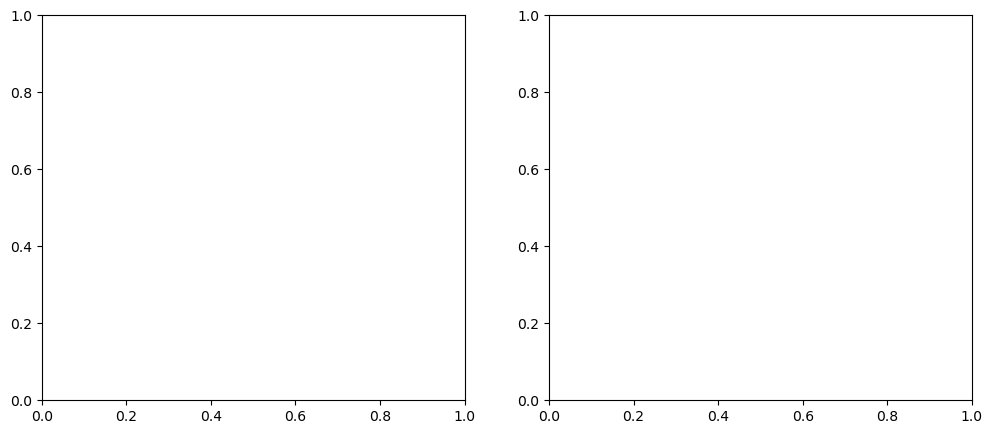

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['HF_DATASETS_OFFLINE'] = '1'

import torch, random
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.utils.data import DataLoader
from transformers import BertTokenizer

from semcom_model import MoE_SemCom, Transformer_SemCom, HetereoMoE_SemCom  # assuming this class exists
from utils import collate_fn, SST2Dataset, fix_seed

# Setup
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
fix_seed(2006) # 2036
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models
model_moe = MoE_SemCom(num_tasks=2, embed_dim=380, task_dim=16, num_experts=8, transmit_dim=128, num_encd_layer=4).to(device) # currently 4 should be 6

model_dense = Transformer_SemCom(num_tasks=2, embed_dim=380, task_dim=16, transmit_dim=128, num_encd_layer=4).to(device)

model_hetereo = HetereoMoE_SemCom(num_tasks=2, embed_dim=380, task_dim=16, num_experts=8, size_distribution='arithmetic', transmit_dim=128, num_encd_layer=4).to(device)  # NEW

model_moe.load_state_dict(torch.load("checkpoints/MoE_decoder_20250601_154918.pt"))
model_dense.load_state_dict(torch.load("checkpoints/Dense_decoder_20250601_064415.pt"))
model_hetereo.load_state_dict(torch.load("checkpoints/HetereoMoE_decoder_20250531_103102.pt"))  # NEW

model_moe.eval()
model_dense.eval()
model_hetereo.eval()

# Load data
dataset = load_dataset("glue", "sst2", cache_dir='/home/necphy/.cache/huggingface/datasets')
# test_dataset = SST2Dataset(dataset['validation'])
# test_dataset = SST2Dataset(dataset['train'])
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

full_train_dataset = dataset['train']
subset_indices = random.sample(range(len(full_train_dataset)), len(full_train_dataset) // 20)
small_train_dataset = full_train_dataset.select(subset_indices)
test_dataset = SST2Dataset(small_train_dataset)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)


snr_range = np.array([6])
# fading_range = ['none', 'rayleigh', 'rician']
k_rician_range = np.array([1, 2, 4, 10, 20, 100]) # linear scale

# Results dicts
results = {
    'dense': {'accuracy': {k: [] for k in k_rician_range}, 'bleu': {k: [] for k in k_rician_range}},
    'moe': {'accuracy': {k: [] for k in k_rician_range}, 'bleu': {k: [] for k in k_rician_range}},
    'hetereoMoE': {'accuracy': {k: [] for k in k_rician_range}, 'bleu': {k: [] for k in k_rician_range}},  # NEW
}

# Main evaluation loop
for snr in snr_range:
    for k in k_rician_range:
        metrics = {arch: {'correct': 0, 'total': 0, 'bleu_scores': []} for arch in results.keys()}

        for texts, labels in test_loader:
            for arch_name, model in [('dense', model_dense), ('moe', model_moe), ('hetereoMoE', model_hetereo)]:
                for task in [0, 1]:
                    with torch.no_grad():
                        if arch_name == 'dense':
                            outputs, input_ids, _, _, _ = model(texts, task, snr=float(snr), fading='rician', rician_k=k)
                        else:
                            outputs, input_ids, input_lengths, semantic_encoded, semantic_decoded, gate_scores, expert_masks = model(texts, task, float(snr), fading='rician', rician_k=k) 

                        if task == 0:  # Classification
                            logits = outputs
                            preds = logits.argmax(dim=-1)
                            metrics[arch_name]['correct'] += (preds == labels.to(device)).sum().item()
                            metrics[arch_name]['total'] += labels.size(0)

                        elif task == 1:  # Reconstruction
                            pred_ids_batch = outputs
                            tgt_ids_batch = input_ids[:, 1:1 + pred_ids_batch.shape[1]]
                            pred_texts = tokenizer.batch_decode(pred_ids_batch, skip_special_tokens=True)
                            target_texts = tokenizer.batch_decode(tgt_ids_batch, skip_special_tokens=True)
                            for pred_text, target_text in zip(pred_texts, target_texts):
                                bleu = sentence_bleu(
                                    [word_tokenize(target_text)],
                                    word_tokenize(pred_text),
                                    weights=(1, 0, 0, 0),
                                    smoothing_function=SmoothingFunction().method4
                                )
                                metrics[arch_name]['bleu_scores'].append(bleu)

        # Aggregate
        for arch_name in results.keys():
            acc = metrics[arch_name]['correct'] / metrics[arch_name]['total']
            bleu = np.mean(metrics[arch_name]['bleu_scores'])
            results[arch_name]['accuracy'][k].append(acc)
            results[arch_name]['bleu'][k].append(bleu)

# Plotting: 3 figures, one per fading
model_types = ['dense', 'moe', 'hetereoMoE']

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
for model in model_types:
    axs[0].plot(k_rician_range, [results[model]['accuracy'][k] for k in k_rician_range], label=model)
axs[0].set_title(f'Accuracy vs Rician K factor')
axs[0].set_xlabel('Rician K factor')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# BLEU plot
for model in model_types:
    axs[1].plot(k_rician_range, [results[model]['bleu'][k] for k in k_rician_range], label=model)
axs[1].set_title(f'BLEU Score vs Rician K factor')
axs[1].set_xlabel('Rician K factor')
axs[1].set_ylabel('BLEU Score')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


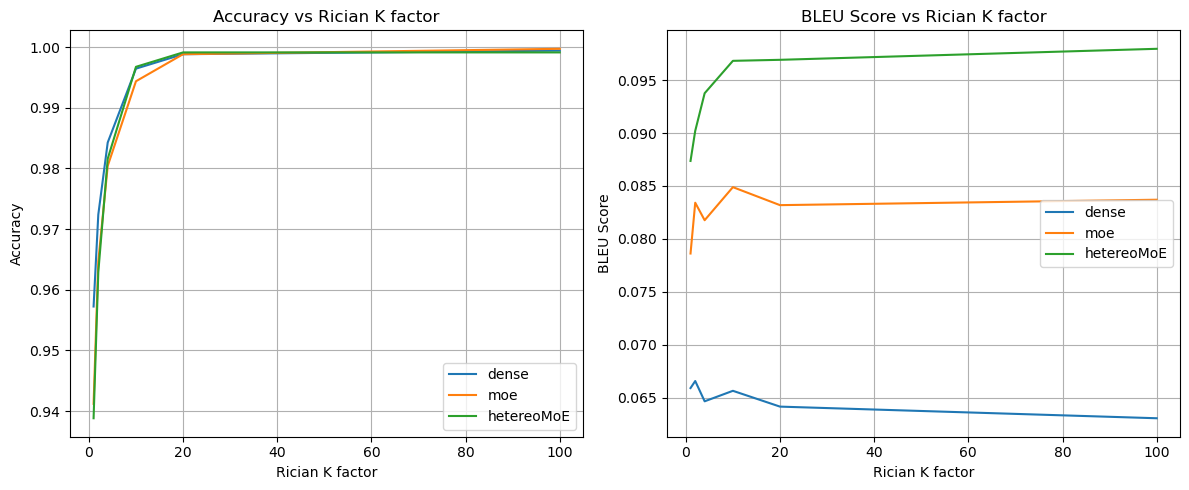

In [ ]:
model_types = ['dense', 'moe', 'hetereoMoE']

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
for model in model_types:
    axs[0].plot(k_rician_range, [results[model]['accuracy'][k] for k in k_rician_range], label=model)
axs[0].set_title(f'Accuracy vs Rician K factor')
axs[0].set_xlabel('Rician K factor')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# BLEU plot
for model in model_types:
    axs[1].plot(k_rician_range, [results[model]['bleu'][k] for k in k_rician_range], label=model)
axs[1].set_title(f'BLEU Score vs Rician K factor')
axs[1].set_xlabel('Rician K factor')
axs[1].set_ylabel('BLEU Score')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.savefig('results/rician_k.png')
plt.show()

/home/necphy/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using the latest cached version of the dataset since glue couldn't be found on the Hugging Face Hub (offline mode is enabled).
Found the latest cached dataset configuration 'sst2' at /home/necphy/.cache/huggingface/datasets/glue/sst2/0.0.0/bcdcba79d07bc864c1c254ccfcedcce55bcc9a8c (last modified on Mon Jun 16 17:42:04 2025).


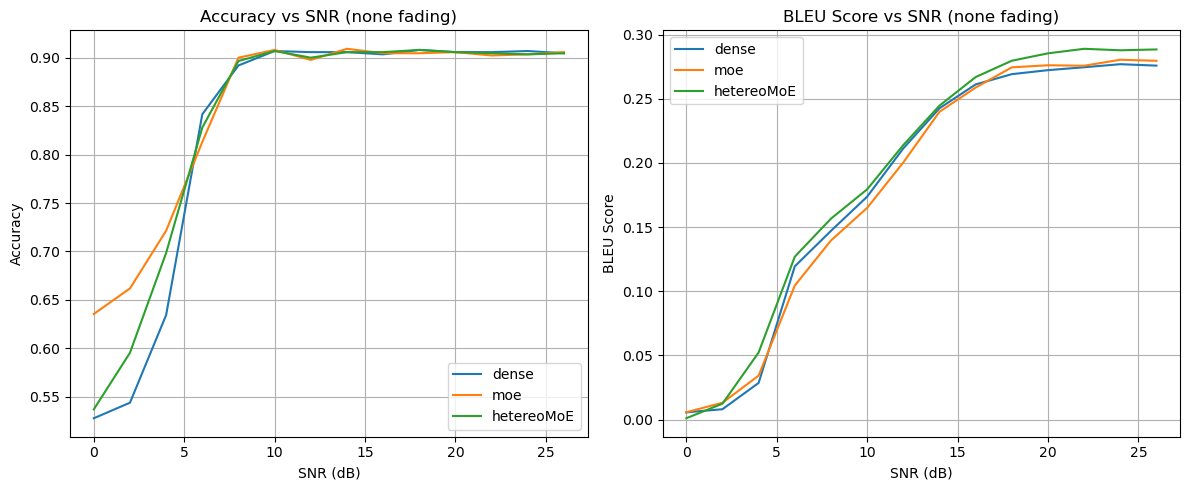

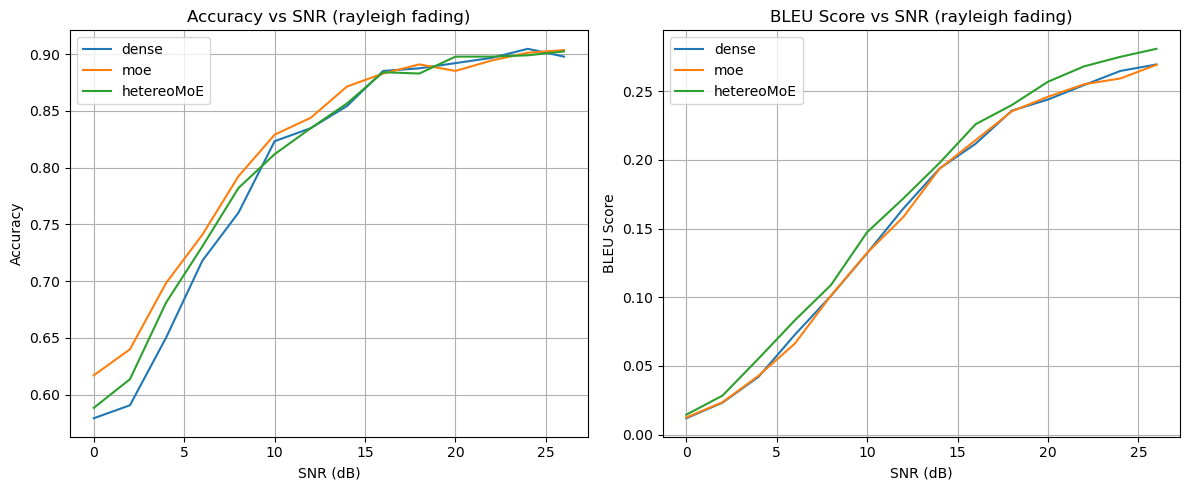

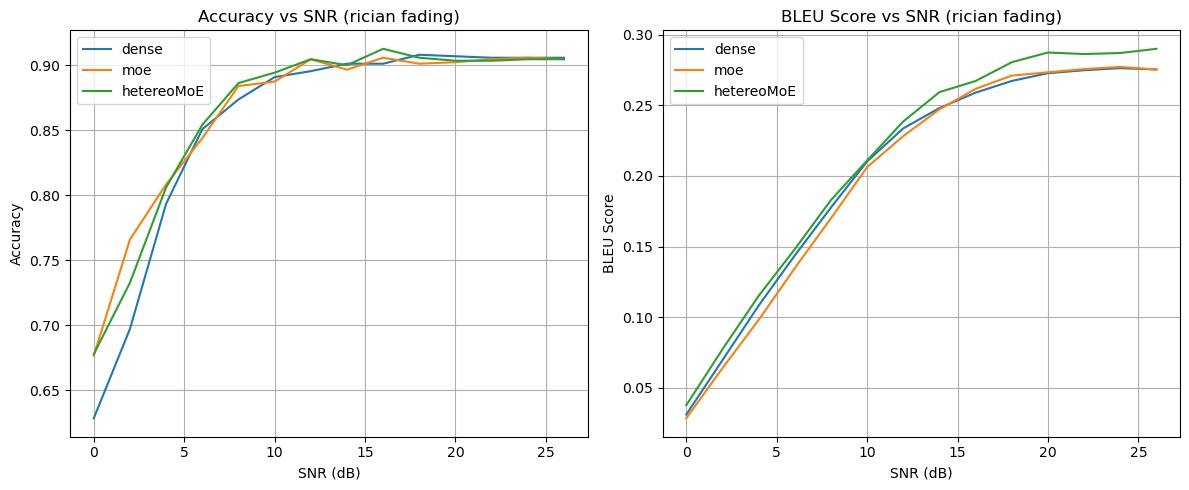

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['HF_DATASETS_OFFLINE'] = '1'

import torch, random
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.utils.data import DataLoader
from transformers import BertTokenizer

from semcom_model import MoE_SemCom, Transformer_SemCom, HetereoMoE_SemCom  # assuming this class exists
from utils import collate_fn, SST2Dataset, fix_seed

# Setup
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# fix_seed(2006) # 2036
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models
model_moe = MoE_SemCom(num_tasks=2, embed_dim=412, task_dim=8, num_experts=8, transmit_dim=128, num_encd_layer=4).to(device) # currently 4 should be 6

model_dense = Transformer_SemCom(num_tasks=2, embed_dim=412, task_dim=8, transmit_dim=128, num_encd_layer=4).to(device)

model_hetereo = HetereoMoE_SemCom(num_tasks=2, embed_dim=412, task_dim=8, num_experts=8, size_distribution='arithmetic', transmit_dim=128, num_encd_layer=4).to(device)  # NEW

model_moe.load_state_dict(torch.load("./checkpoints/MoE_complete.pt", weights_only=True))
model_dense.load_state_dict(torch.load("./checkpoints/Dense_complete.pt", weights_only=True))
model_hetereo.load_state_dict(torch.load("./checkpoints/HetereoMoE_complete.pt", weights_only=True))  # NEW

model_moe.eval()
model_dense.eval()
model_hetereo.eval()

# Load data
dataset = load_dataset("glue", "sst2", cache_dir='/home/necphy/.cache/huggingface/datasets')

test_dataset = SST2Dataset(dataset['validation'])
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, collate_fn=collate_fn)

# full_train_dataset = dataset['train']
# subset_indices = random.sample(range(len(full_train_dataset)), len(full_train_dataset) // 50)
# small_train_dataset = full_train_dataset.select(subset_indices)
# test_dataset = SST2Dataset(small_train_dataset)
# test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, collate_fn=collate_fn)


snr_range = np.arange(0, 28, 2)
fading_range = ['none', 'rayleigh', 'rician']

# Results dicts
results = {
    'dense': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
    'moe': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
    'hetereoMoE': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},  #
}


# Main evaluation loop
for snr in snr_range:
    for fading in fading_range:
        metrics = {arch: {'correct': 0, 'total': 0, 'bleu_scores': []} for arch in results.keys()}

        for texts, labels in test_loader:
            for arch_name, model in [('dense', model_dense), ('moe', model_moe), ('hetereoMoE', model_hetereo),]:  # NEW
                for task in [0, 1]:
                    with torch.no_grad():
                        if arch_name == 'dense':
                            outputs, input_ids, _, _, _ = model(texts, task, snr=float(snr), fading=fading)
                        else:
                            outputs, input_ids, input_lengths, semantic_encoded, semantic_decoded, gate_scores, expert_masks = model(texts, task, float(snr), fading) 


                        if task == 0:  # Classification
                            preds = outputs.argmax(dim=-1)
                            metrics[arch_name]['correct'] += (preds == labels.to(device)).sum().item()
                            metrics[arch_name]['total'] += labels.size(0)

                        elif task == 1:  # Reconstruction
                            pred_ids_batch = outputs.argmax(dim=-1).cpu().tolist()

                            tgt_ids_batch = input_ids[:, :len(pred_ids_batch[0])].cpu().tolist()  # Adjusted to match pred_ids_batch length

                            pred_texts = tokenizer.batch_decode(pred_ids_batch, skip_special_tokens=True)
                            target_texts = tokenizer.batch_decode(tgt_ids_batch, skip_special_tokens=True)

                            for pred_text, target_text in zip(pred_texts, target_texts):
                                bleu = sentence_bleu(
                                    [word_tokenize(target_text)],
                                    word_tokenize(pred_text),
                                    weights=(1, 0, 0, 0),
                                    smoothing_function=SmoothingFunction().method4
                                )
                                metrics[arch_name]['bleu_scores'].append(bleu)

        # Aggregate
        for arch_name in results.keys():
            acc = metrics[arch_name]['correct'] / metrics[arch_name]['total']
            bleu = np.mean(metrics[arch_name]['bleu_scores'])
            results[arch_name]['accuracy'][fading].append(acc)
            results[arch_name]['bleu'][fading].append(bleu)

# Plotting: 3 figures, one per fading
model_types = ['dense', 'moe', 'hetereoMoE']  # NEW

for fading in fading_range:
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Accuracy plot
    for model in model_types:
        axs[0].plot(snr_range, results[model]['accuracy'][fading], label=model)
    axs[0].set_title(f'Accuracy vs SNR ({fading} fading)')
    axs[0].set_xlabel('SNR (dB)')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()
    axs[0].grid(True)

    # BLEU plot
    for model in model_types:
        axs[1].plot(snr_range, results[model]['bleu'][fading], label=model)
    axs[1].set_title(f'BLEU Score vs SNR ({fading} fading)')
    axs[1].set_xlabel('SNR (dB)')
    axs[1].set_ylabel('BLEU Score')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

/home/necphy/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_77501/3427882420.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weight

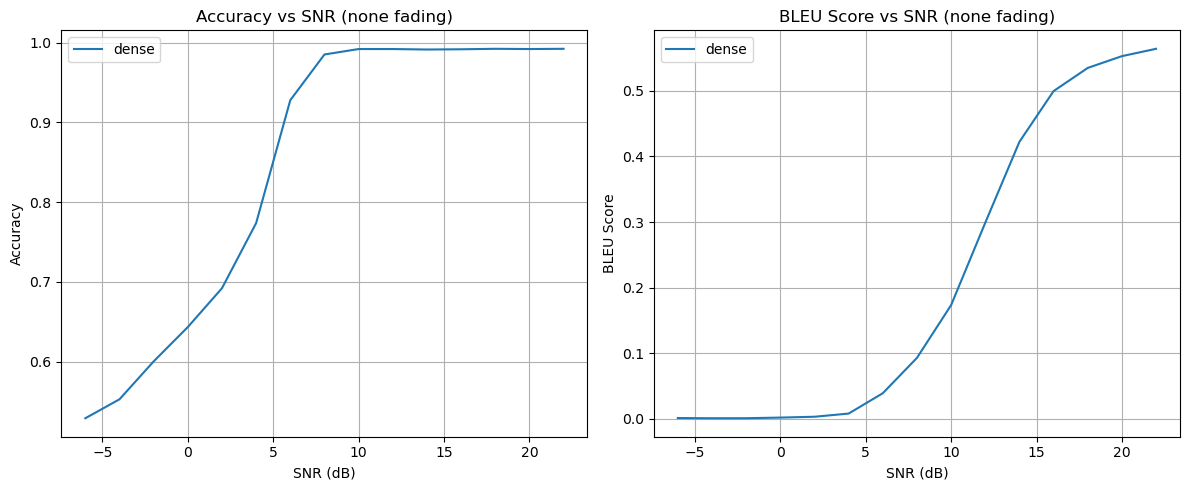

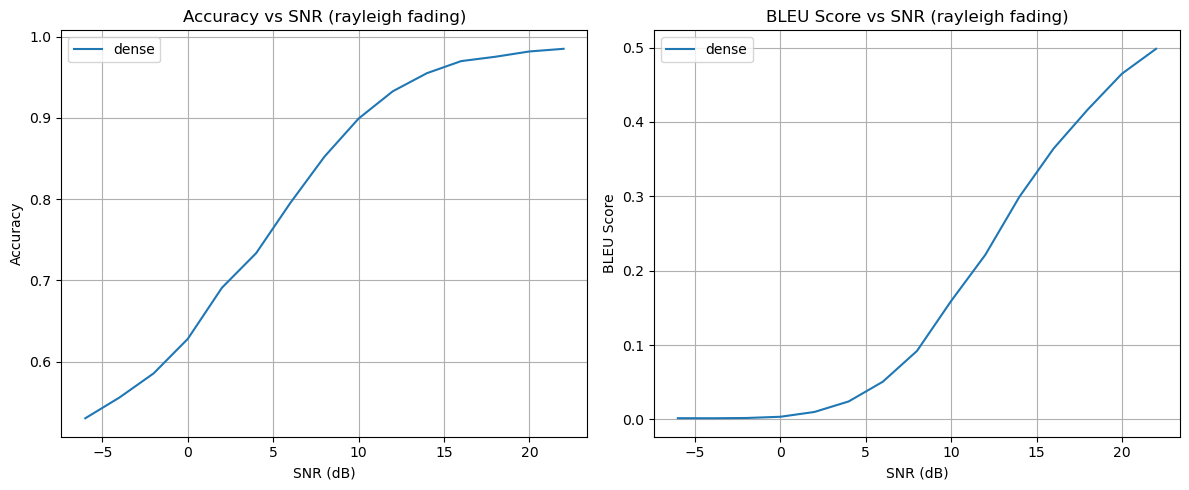

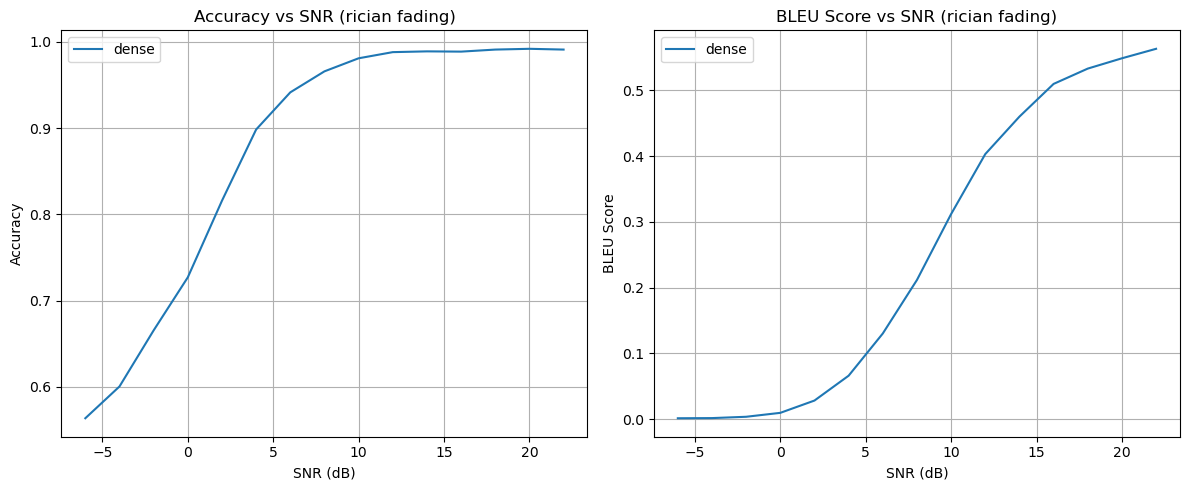

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['HF_DATASETS_OFFLINE'] = '1'

import torch, random
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.utils.data import DataLoader
from transformers import BertTokenizer

from semcom_model import MoE_SemCom, Transformer_SemCom, HetereoMoE_SemCom  # assuming this class exists
from utils import collate_fn, SST2Dataset, fix_seed

# Setup
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
fix_seed(2006) # 2036
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models
# model_moe = MoE_SemCom(num_tasks=2, embed_dim=380, task_dim=16, num_experts=8, transmit_dim=128, num_encd_layer=4).to(device) # currently 4 should be 6
# model_moe = Transformer_SemCom(num_tasks=2, embed_dim=412, task_dim=8, num_encd_layer=4, transmit_dim=256).to(device)

model_dense = Transformer_SemCom(num_tasks=2, embed_dim=412, task_dim=8, num_encd_layer=4, transmit_dim=128).to(device)

# model_hetereo = HetereoMoE_SemCom(num_tasks=2, embed_dim=380, task_dim=16, num_experts=8, size_distribution='arithmetic', transmit_dim=128, num_encd_layer=4).to(device)  # NEW

# model_moe.load_state_dict(torch.load("checkpoints/Dense_snr12_20250604_055257.pt"))

model_dense.load_state_dict(torch.load("checkpoints/Dense_newMI_20250613_142628.pt"))
# model_hetereo.load_state_dict(torch.load("checkpoints/HetereoMoE_decoder_20250531_103102.pt"))  # NEW

# model_moe.eval()
model_dense.eval()
# model_hetereo.eval()

# Load data
dataset = load_dataset("glue", "sst2", cache_dir='/home/necphy/.cache/huggingface/datasets')

# test_dataset = SST2Dataset(dataset['validation'])
# test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)

full_train_dataset = dataset['train']
subset_indices = random.sample(range(len(full_train_dataset)), len(full_train_dataset) // 20)
small_train_dataset = full_train_dataset.select(subset_indices)
test_dataset = SST2Dataset(small_train_dataset)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)


snr_range = np.arange(-6, 24, 2)
fading_range = ['none', 'rayleigh', 'rician']

# Results dicts
results = {
    'dense': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
    # 'moe': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
    # 'hetereoMoE': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},  #
}


# Main evaluation loop
for snr in snr_range:
    for fading in fading_range:
        metrics = {arch: {'correct': 0, 'total': 0, 'bleu_scores': []} for arch in results.keys()}

        for texts, labels in test_loader:
            # for arch_name, model in [('dense', model_dense), ('moe', model_moe), ('hetereoMoE', model_hetereo),]:  # NEW
            for arch_name, model in [('dense', model_dense),]:  # NEW

                for task in [0, 1]:
                    with torch.no_grad():
                        # if arch_name == 'dense':
                        if True:
                            outputs, input_ids, _, _, _ = model(texts, task, snr=float(snr), fading=fading)
                        # else:
                        #     outputs, input_ids, input_lengths, semantic_encoded, semantic_decoded, gate_scores, expert_masks = model(texts, task, float(snr), fading) 


                        if task == 0:  # Classification
                            preds = outputs.argmax(dim=-1)
                            metrics[arch_name]['correct'] += (preds == labels.to(device)).sum().item()
                            metrics[arch_name]['total'] += labels.size(0)

                        elif task == 1:  # Reconstruction
                            pred_ids_batch = outputs.argmax(dim=-1).cpu().tolist()

                            tgt_ids_batch = input_ids[:, :len(pred_ids_batch[0])].cpu().tolist()  # Adjusted to match pred_ids_batch length

                            pred_texts = tokenizer.batch_decode(pred_ids_batch, skip_special_tokens=True)
                            target_texts = tokenizer.batch_decode(tgt_ids_batch, skip_special_tokens=True)

                            for pred_text, target_text in zip(pred_texts, target_texts):
                                bleu = sentence_bleu(
                                    [word_tokenize(target_text)],
                                    word_tokenize(pred_text),
                                    weights=(1, 0, 0, 0),
                                    smoothing_function=SmoothingFunction().method4
                                )
                                metrics[arch_name]['bleu_scores'].append(bleu)

        # Aggregate
        for arch_name in results.keys():
            acc = metrics[arch_name]['correct'] / metrics[arch_name]['total']
            bleu = np.mean(metrics[arch_name]['bleu_scores'])
            results[arch_name]['accuracy'][fading].append(acc)
            results[arch_name]['bleu'][fading].append(bleu)

# Plotting: 3 figures, one per fading
# model_types = ['dense', 'moe', 'hetereoMoE']  # NEW
model_types = ['dense',]  # NEW


for fading in fading_range:
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Accuracy plot
    for model in model_types:
        axs[0].plot(snr_range, results[model]['accuracy'][fading], label=model)
    axs[0].set_title(f'Accuracy vs SNR ({fading} fading)')
    axs[0].set_xlabel('SNR (dB)')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()
    axs[0].grid(True)

    # BLEU plot
    for model in model_types:
        axs[1].plot(snr_range, results[model]['bleu'][fading], label=model)
    axs[1].set_title(f'BLEU Score vs SNR ({fading} fading)')
    axs[1].set_xlabel('SNR (dB)')
    axs[1].set_ylabel('BLEU Score')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['HF_DATASETS_OFFLINE'] = '1'

import torch, random
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.utils.data import DataLoader
from transformers import BertTokenizer

from semcom_model import MoE_SemCom, Transformer_SemCom, HetereoMoE_SemCom  # assuming this class exists
from utils import collate_fn, SST2Dataset, fix_seed

# Setup
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# fix_seed(2006) # 2036
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



model_dense = Transformer_SemCom(num_tasks=2, embed_dim=412, task_dim=8, num_encd_layer=4, transmit_dim=128).to(device)

# model_hetereo = HetereoMoE_SemCom(num_tasks=2, embed_dim=380, task_dim=16, num_experts=8, size_distribution='arithmetic', transmit_dim=128, num_encd_layer=4).to(device)  # NEW

# model_moe.load_state_dict(torch.load("checkpoints/Dense_snr12_20250604_055257.pt"))

model_dense.load_state_dict(torch.load("checkpoints/Dense_newMI_20250613_142628.pt"))

for name, param in model_dense.named_parameters():
    if 'channel_encoder' in name or 'channel_decoder' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

for name, param in model_dense.named_parameters():
    if param.requires_grad:
        print(f"Trainable param: {name} - {param.shape}")

/home/necphy/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Trainable param: channel_encoder.0.weight - torch.Size([1680, 420])
Trainable param: channel_encoder.0.bias - torch.Size([1680])
Trainable param: channel_encoder.2.weight - torch.Size([128, 1680])
Trainable param: channel_encoder.2.bias - torch.Size([128])
Trainable param: channel_decoder.0.weight - torch.Size([1680, 128])
Trainable param: channel_decoder.0.bias - torch.Size([1680])
Trainable param: channel_decoder.2.weight - torch.Size([420, 1680])
Trainable param: channel_decoder.2.bias - torch.Size([420])


/tmp/ipykernel_87440/4255863462.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dense.load_state_dict(torch.load("checkpoints/Dense_newMI_20250613_142628.pt"))


In [1]:
#to-do: compute total number of parameters in the model table
def count_params_exclude(model, exclude_prefixes=['text_encoder', 'output_head']):
    total_params = 0
    for name, param in model.named_parameters():
        if not any([name.startswith(prefix) for prefix in exclude_prefixes]):
            total_params += param.numel()
    return total_params

def count_params(model):
    total_params = 0
    for param in model.parameters():
        total_params += param.numel()
    return total_params

def count_specific_params(model, prefix):
    total_params = 0
    for name, param in model.named_parameters():
        if name.startswith(prefix):
            total_params += param.numel()
    return total_params


def count_hmoe_active_params(model, top_k=2, exclude_prefixes=('text_encoder')):
    # Track params for each expert in each layer
    expert_param_counts = defaultdict(lambda: defaultdict(int))  # layer_idx -> expert_idx -> param_count
    non_expert_param_count = 0
    
    for name, param in model.named_parameters():
        if any([name.startswith(prefix) for prefix in exclude_prefixes]):
            continue
        if ".experts." in name:
            # Example: encoder_transformer.layers.0.moe_ffn.experts.7.2.weight
            parts = name.split('.')
            # print(f"Parsing param: {name} --> parts: {parts}")  # Add this line!

            try:
                layer_idx = int(parts[2])
                expert_idx = int(parts[5])
                # print(f"  Got layer {layer_idx}, expert {expert_idx}")

            except Exception:
                # print(f"  Failed to parse: {e}")

                # Might not match expected format, just skip
                continue
            expert_param_counts[layer_idx][expert_idx] += param.numel()
        else:
            non_expert_param_count += param.numel()
    
    # Now, sum active expert params: for each layer, sum the top_k experts' param counts
    min_expert_param_count = 0
    max_expert_param_count = 0
 
    for layer_idx, expert_dict in expert_param_counts.items():
        min_selected_experts = sorted(expert_dict.keys())[:top_k]
        max_selected_experts = sorted(expert_dict.keys())[-top_k:]

        # print(f"Layer {layer_idx}: all experts: {sorted(expert_dict.keys())}, selected: {selected_experts}")

        for expert_idx in min_selected_experts:
            min_expert_param_count += expert_dict[expert_idx]

        for expert_idx in max_selected_experts:
            max_expert_param_count += expert_dict[expert_idx]

    total_min_param_count = non_expert_param_count + min_expert_param_count
    total_max_param_count = non_expert_param_count + max_expert_param_count

    return total_min_param_count, total_max_param_count, non_expert_param_count


import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['HF_DATASETS_OFFLINE'] = '1'

import torch, random
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.utils.data import DataLoader
from transformers import BertTokenizer

from semcom_model import MoE_SemCom, Transformer_SemCom, HetereoMoE_SemCom  # assuming this class exists
from utils import collate_fn, SST2Dataset, fix_seed

# Setup
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# fix_seed(2006) # 2036
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")  # For testing purposes, we can use CPU

# MODEL_SIZE = 'S'  # 'S', 'M', 'L'
NUM_LAYERS = 4
D_TRANSFORMER = 412
N_HEADS = 6
NUM_EXPERTS = 16

# model_dense = Transformer_SemCom(num_tasks=2, embed_dim=D_TRANSFORMER, task_dim=8, num_encd_layer=NUM_LAYERS, transmit_dim=128, num_heads=N_HEADS).to(device)
model_dense = HetereoMoE_SemCom(num_tasks=2, embed_dim=D_TRANSFORMER, task_dim=8, num_encd_layer=NUM_LAYERS, transmit_dim=128, num_heads=N_HEADS, num_experts=NUM_EXPERTS, size_distribution='arithmetic').to(device)

print(count_params_exclude(model_dense, exclude_prefixes=['text_encoder']))
print(count_hmoe_active_params(model_dense, top_k=2, exclude_prefixes=['text_encoder']))

/home/necphy/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


120067152
(31032192, 50812512, 29615952)
